### This phase of the development notebook is mostly to figure out the TBC code, and refine the video RF decoding code.

In [1]:
# Just your usual setup

import numpy as np
import scipy as sp
import scipy.signal as sps
import scipy.fftpack as fftpack 
import matplotlib.pyplot as plt
import sys
import getopt

%matplotlib inline

import matplotlib
matplotlib.rc('figure', figsize=(20, 12))

from datetime import  datetime

import fft8 as fft8 
import ld_utils as utils

import copy

# for image display
from PIL import Image
from IPython.display import HTML
import IPython.display 
from io import BytesIO
from base64 import b64encode

In [2]:
pi = np.pi
tau = np.pi * 2

# Optimal if this is a power of 2
blocklenk = 16
blocklen = (blocklenk * 1024)
# may need to adjust this depending on block length
blockcut = 512

In [3]:
# charting/graphing code carried over from earlier development efforts

def dosplot(B, A, freq = (315.0/88.0) * 8.0):
    w, h = sps.freqz(B, A)

    fig = plt.figure()
    plt.title('Digital filter frequency response')

    ax1 = fig.add_subplot(111)

    db = 20 * np.log10(abs(h))

    for i in range(1, len(w)):
        if (db[i] >= -10) and (db[i - 1] < -10):
            print(">-10db crossing at ", w[i] * (freq/pi) / 2.0) 
        if (db[i] >= -3) and (db[i - 1] < -3):
            print("-3db crossing at ", w[i] * (freq/pi) / 2.0) 
        if (db[i] < -3) and (db[i - 1] >= -3):
            print("<-3db crossing at ", w[i] * (freq/pi) / 2.0) 
        if (db[i] < -10) and (db[i - 1] >= -10):
            print("<-10db crossing at ", w[i] * (freq/pi) / 2.0) 
        if (db[i] < -20) and (db[i - 1] >= -20):
            print("<-20db crossing at ", w[i] * (freq/pi) / 2.0) 

    plt.plot(w * (freq/pi) / 2.0, 20 * np.log10(abs(h)), 'b')
    plt.ylabel('Amplitude [dB]', color='b')
    plt.xlabel('Frequency [rad/sample]')

    plt.show()

def doplot(B, A, freq = (315.0/88.0) * 8.0):
    w, h = sps.freqz(B, A)

    fig = plt.figure()
    plt.title('Digital filter frequency response')

    db = 20 * np.log10(abs(h))
    for i in range(1, len(w)):
        if (db[i] >= -10) and (db[i - 1] < -10):
            print(">-10db crossing at ", w[i] * (freq/pi) / 2.0) 
        if (db[i] >= -3) and (db[i - 1] < -3):
            print(">-3db crossing at ", w[i] * (freq/pi) / 2.0) 
        if (db[i] < -3) and (db[i - 1] >= -3):
            print("<-3db crossing at ", w[i] * (freq/pi) / 2.0) 

    ax1 = fig.add_subplot(111)

    plt.plot(w * (freq/pi) / 2.0, 20 * np.log10(abs(h)), 'b')
    plt.ylabel('Amplitude [dB]', color='b')
    plt.xlabel('Frequency [rad/sample]')

    ax2 = ax1.twinx()
    angles = np.unwrap(np.angle(h))
    plt.plot(w * (freq/pi) / 2.0, angles, 'g')
    plt.ylabel('Angle (radians)', color='g')

    plt.grid()
    plt.axis('tight')
    plt.show()

# plot two filters (haven't tested in a long while!)
def doplot2(B, A, B2, A2, freq = (315.0/88.0) * 8.0):
    w, h = sps.freqz(B, A)
    w2, h2 = sps.freqz(B2, A2)

    begin = 0
    end = len(w)
    chop = 0

    w = w[begin:end]
    w2 = w2[begin:end]
    h = h[begin:end]
    h2 = h2[begin:end]

    v = np.empty(len(w))

    hm = np.absolute(h)
    hm2 = np.absolute(h2)

    v0 = hm[0] / hm2[0]
    for i in range(0, len(w)):
        v[i] = (hm[i] / hm2[i]) / v0

    fig = plt.figure()
    plt.title('Digital filter frequency response')

    ax1 = fig.add_subplot(111)

    v  = 20 * np.log10(v )

    plt.plot(w * (freq/pi) / 2.0, 20 * np.log10(abs(h)), 'r')
    plt.plot(w * (freq/pi) / 2.0, 20 * np.log10(abs(h2)), 'b')
    plt.ylabel('Amplitude [dB]', color='b')
    plt.xlabel('Frequency [rad/sample]')

    ax2 = ax1.twinx()
    angles = np.unwrap(np.angle(h))
    angles2 = np.unwrap(np.angle(h2))
    plt.plot(w * (freq/pi) / 2.0, angles, 'g')
    plt.plot(w * (freq/pi) / 2.0, angles2, 'y')
    plt.ylabel('Angle (radians)', color='g')

    plt.grid()
    plt.axis('tight')
    plt.show()

# This matches FDLS-based conversion surprisingly well (i.e. FDLS is more accurate than I thought ;) )
def BA_to_FFT(B, A, blocklen):
    return np.complex64(sps.freqz(B, A, blocklen, whole=True)[1])

# Draws a uint16 image as a uint8, defaults to one frame
def drawdata(bm, x = 2800, y = 525, hscale = 1, vscale = 2, outsize = None):
#    bmf = np.float32(bm) / 65536.0
    if y is None:
        y = len(bm) // x
        
    if outsize is None:
        outsize = (x * hscale, y * vscale)
    
    bmf = np.uint8(bm[0:x*y] / 256.0)
    print(bmf.shape)
    if x is not None:
        bms = (bmf.reshape(len(bmf)//x, -1))
    else:
        bms = bmf
    
    print(bms.dtype, bms.shape, bms[:][0:y].shape)
    im = Image.fromarray(bms[0:y])
    im = im.resize(outsize)
    b = BytesIO()
    im.save(b, format='png')
    return IPython.display.Image(b.getvalue())


In [4]:
# System default specs for NTSC and PAL.

NTSC_hz_ire = (9300000 - 7600000) / 140.0 # Later disks may have a higher white point

SysParams_NTSC = {
    'system_name': 'NTSC',
    
    'audio_lfreq': 2301136,
    'audio_rfreq': 2812499,

    'analog_audio': True,

    'fsc_mhz': (315.0 / 88.0),
    'line_period': 63.5, # in usecs

    # video frequencies 
    # per spec, range from -40 to 100 IRE is 1.7mhz, so 12142 ire/mhz
    'hz_ire': NTSC_hz_ire,
    
    'videorf_sync'  : 8100000-(NTSC_hz_ire * -40),
    'videorf_0ire'  : 8100000,
    'videorf_7.5ire': 8100000+(NTSC_hz_ire*7.5),
    'videorf_100ire': 8100000+(NTSC_hz_ire*100), # NOTE: slightly higher on later disks

    # IRE range is actually -40 to 110, but leave some margin here and match 0-65534 scaling
    'ire_min': -60,
    'ire_max': 140,

    # tunable parameters.  These work well with DD 2_2 + eliptical filter, which is a bit more
    # picky about audio RF filtering.
    
    #'deemp': (120, 320), # actual deemp timing... at least the usec #'s.
    'deemp': (120*.7, 320*.7), # On some captures this is as low as .55.

    # The audio notch filters didn't work right until the ellipcital filter was implemented...
    'audio_filtwidth': 150000,
    'audio_filtorder': 2,

    # similar but not identical to what Pioneer did
    'vbpf': (3500000, 13200000),
    'vbpf_order': 3,
    
    # This can easily be pushed up to 4.5mhz...
    'vlpf_freq': 4200000,   # in mhz
    'vlpf_order': 5 # butterworth filter order
    
}

SysParams_PAL = {
    # System parameters
    'system_name': 'PAL',

    'fsc_mhz': 4.43361875,
    'line_period': 64, # in usecs
    
    'audio_lfreq': 683593,
    'audio_rfreq': 1066400,

    # video frequencies 
    'videorf_sync': 6760000, # on LD this includes a very strong pilot signal
    'videorf_0ire': 7100000,
    'videorf_100ire': 7900000,

    'ire_min': -95, # needed for pilot signal
    'ire_max': 145,

    # changeable defaults
    'analog_audio': False, # not true for later PAL

    'deemp': (100, 400),

    # XXX: guessing here!
    'vbpf': (2600000, 11000000),
    'vbpf_order': 3,
    'vlpf_freq': 4800000,	# in mhz
    'vlpf_order': 5,		# butterworth filter order

    'audio_filtwidth': 200000,
    'audio_filtorder': 1,
}

# support reloading/rerunning from ipython
try:
    # a dummy load
    tmp = SysParams['fsc_mhz']
except:
    SysParams = copy.deepcopy(SysParams_NTSC)
    

In [5]:
params = {'freq': 40}

for p in [SysParams_NTSC]:
    for k in p.keys():
        print(k, p[k])
        params[k] = p[k]

system_name NTSC
audio_lfreq 2301136
audio_rfreq 2812499
analog_audio True
fsc_mhz 3.5795454545454546
line_period 63.5
hz_ire 12142.857142857143
videorf_sync 8585714.285714285
videorf_0ire 8100000
videorf_7.5ire 8191071.428571428
videorf_100ire 9314285.714285715
ire_min -60
ire_max 140
deemp (84.0, 224.0)
audio_filtwidth 150000
audio_filtorder 2
vbpf (3500000, 13200000)
vbpf_order 3
vlpf_freq 4200000
vlpf_order 5


In [6]:
def inrange(a, mi, ma):
    return (a >= mi) & (a <= ma)

def sqsum(cmplx):
    return np.sqrt((cmplx.real ** 2) + (cmplx.imag ** 2))

In [7]:
# from http://tlfabian.blogspot.com/2013/01/implementing-hilbert-90-degree-shift.html
hilbert_filter = np.fft.fftshift(
    np.fft.ifft([0]+[1]*200+[0]*200)
)

# Now construct the FFT transform of the hilbert filter.  
# This can be complex multiplied with the raw RF to do the 'heavy lifting'
fft_hilbert = np.fft.fft(hilbert_filter, blocklen)

def filtfft(filt, blen = blocklen):
    return sps.freqz(filt[0], filt[1], blen, whole=1)[1]

Decoding notes:

- My RF decoder is based off frequency-domain transforms.  This allows multiple filters to be applied in one operation, and multiple different filters can also be applied, which will come into play when working on audio

In [8]:
# A rather pants attempt at doing an MTF function, but it seems to work well...
[tf_b, tf_a] = sps.zpk2tf(.1, -.5, 1.0)
Fmtf = filtfft([tf_b, tf_a])

# This prepares the needed transforms to do the actual video decoding
def prepare_video_filters(params):
    SP = copy.deepcopy(params)
    
    SP['freq_hz'] = SP['freq'] * 1000000.0
    SP['line_px'] = SP['freq_hz'] * (SP['line_period'] / 1000000.0)
        
    freq_hz = SP['freq_hz']
    freq_hz_half = SP['freq_hz'] / 2
    freq_half = SP['freq'] / 2

    # RF BPF and analog audio cut filters
    SP['FRFVideo'] = filtfft(sps.butter(SP['vbpf_order'], [SP['vbpf'][0]/freq_hz_half, SP['vbpf'][1]/freq_hz_half], btype='bandpass'))
    
    # If there is analog audio, it must be filtered well especially with DD >=2.2 RF captures
    if SP['analog_audio'] and SP['audio_filtorder']: 
        SP['Fcutl'] = filtfft(sps.butter(SP['audio_filtorder'], [(SP['audio_lfreq'] - SP['audio_filtwidth'])/freq_hz_half, (SP['audio_lfreq'] + SP['audio_filtwidth'])/(freq_hz_half)], btype='bandstop'))
        SP['Fcutr'] = filtfft(sps.butter(SP['audio_filtorder'], [(SP['audio_rfreq'] - SP['audio_filtwidth'])/freq_hz_half, (SP['audio_rfreq'] + SP['audio_filtwidth'])/(freq_hz_half)], btype='bandstop'))
        
        SP['FRFVideo'] *= (SP['Fcutl'] * SP['Fcutr'])
    
    # standard post-demod LPF
    SP['Fvideo_lpf'] = filtfft(sps.butter(SP['vlpf_order'], SP['vlpf_freq']/freq_hz_half, 'low')) # standard 4.Xmhz

    # post-demodulation deemphasis filter
    [tf_b, tf_a] = sps.zpk2tf(-SP['deemp'][1]*(10**-10)/2.0, -SP['deemp'][0]*(10**-10)/2.0, SP['deemp'][0] / SP['deemp'][1])
    SP['Fdeemp'] = filtfft(sps.bilinear(tf_b, tf_a, 1.0/freq_hz_half))

    # Post processing:  lowpass filter + deemp
    SP['FVideo'] = SP['Fvideo_lpf'] * SP['Fdeemp'] 
    
    # additional filters:  0.5mhz and color burst
    SP['F0_5'] = filtfft(sps.butter(1, 0.5/freq_half, 'low')) 
    SP['FVideo05'] = SP['Fvideo_lpf'] * SP['Fdeemp']  * SP['F0_5']

    if SP['system_name'] == 'NTSC':
        SP['Fcburst'] = filtfft(sps.butter(1, [(SP['fsc_mhz'] * .95)/freq_half, (SP['fsc_mhz'] * 1.05)/freq_half], btype='bandpass')) 
    else:
        SP['Fcburst'] = filtfft(sps.butter(1, [3.7/freq_half, 3.8/freq_half], btype='bandpass')) 
        
    SP['FVideoBurst'] = SP['Fvideo_lpf'] * SP['Fdeemp']  * SP['Fcburst']
    
    # emperical work determined that a single-pole low frequency filter effectively 
    # detects the end of a (regular) sync pulse when binary level detection is used. TODO: test with PAL
    f = sps.butter(1, 0.05/(params['freq'] / 2.0), btype='low')
    SP['FPsync'] = filtfft(f)
    
    return SP

In [9]:
# The actual video demodulation code

def dodemod(paramsc, data, clip = None, usemtf = False, cutarf = False):
    indata_fft = np.fft.fft(data)
    indata_fft_filt = indata_fft * paramsc['FRFVideo']

    if usemtf:
        indata_fft_filt *= Fmtf

    hilbert = np.fft.ifft(indata_fft_filt * fft_hilbert)

    tangles = np.angle(hilbert)
    dangles = np.pad(np.diff(tangles), (1, 0), mode='constant')

    # make sure unwapping goes the right way
    if (dangles[0] < -pi):
        dangles[0] += tau

    tdangles2 = np.unwrap(dangles) 
    # With extremely bad data, the unwrapped angles can jump.
    while np.min(tdangles2) < 0:
        tdangles2[tdangles2 < 0] += tau
    while np.max(tdangles2) > tau:
        tdangles2[tdangles2 > tau] -= tau
    demod = (tdangles2 * (paramsc['freq_hz'] / tau))

    demod_fft = np.fft.fft(demod)
    
    out_video = np.fft.ifft(demod_fft * paramsc['FVideo']).real
    out_video05 = np.fft.ifft(demod_fft * paramsc['FVideo05']).real
    out_videoburst = np.fft.ifft(demod_fft * paramsc['FVideoBurst']).real
    
    # NTSC: filtering for vsync pulses from -55 to -25ire seems to work well even on rotted disks
    output_sync = (out_video > (params['videorf_0ire'] + (params['hz_ire'] * -55))) & (out_video < (params['videorf_0ire'] + (params['hz_ire'] * -25)))
    # Perform FFT convolution of above filter
    output_syncf = np.fft.ifft(np.fft.fft(output_sync) * filterset['FPsync']).real
    
    return np.rec.array([out_video, out_video05, output_syncf, out_videoburst], names=['demod', 'demod_05', 'demod_sync', 'demod_burst'])
    #return out_video, out_video05, out_videoburst

In [10]:
def lineplot(output, param):
    plt.plot(output)
    
    if param['system_name'] == 'PAL':
        plt.axhline(7100000, color='black') # black
        plt.axhline(7900000, color='black') # white

        # burst
        plt.axhline(7100000 - (800000 * 1.5 / 7), color='g')
        plt.axhline(7100000 + (800000 * 1.5 / 7), color='g')

        # pilot low (pilot high is 7.1mhz)
        plt.axhline((7900000-(800000/.7))-(800000*(3/7)), color='b')
    else: # NTSC
        
        plt.axhline(params['videorf_0ire'], color='black') # 0IRE
        plt.axhline(params['videorf_7.5ire'], color='black') # black for most disks
        plt.axhline(params['videorf_100ire'], color='black') # white

        plt.axhline(params['videorf_0ire'] + (params['hz_ire'] * 80), color='blue')
        
        plt.axhline(params['videorf_0ire'] + (params['hz_ire'] * 20), color='green')
        plt.axhline(params['videorf_0ire'] - (params['hz_ire'] * 20), color='green')
        
        # sync
        plt.axhline(params['videorf_0ire'] + (params['hz_ire'] * -40), color='blue')

In [11]:
def calcsnr(a):
    stdire = np.std(a) / NTSC_hz_ire
    return(20 * np.log10(100 / stdire))

In [12]:
# old lddecode format for hz->uint16 conversion
minire = -60
maxire = 140
hz_ire_scale = (9300000 - 8100000) / 100
minn = 8100000 + (hz_ire_scale * -60)
out_scale = 65534.0 / (maxire - minire)

In [13]:
def demod(infile, _start, _end, filterset):
    infile_len = infile.seek(0, 2)
    
    if _end > infile_len:
        end = infile_len
    else:
        end = _end
    
    if (_start > blockcut):
        start = _start - blockcut
    else:
        start = 0 # should this be an error?  prolly.

    print(start, end, (end - start))
    
    # set a placeholder
    output = None #np.zeros(end - start + 1, dtype=('double, double, double'))
        
    for i in range(0, end - start, blocklen - blockcut):
        infile.seek(i * sampletype, 0)
        inbuf = infile.read(blocklen * sampletype)
        
        if sampletype == 2:
            indata = np.fromstring(inbuf, 'int16', len(inbuf) // 2)
        else:
            indata = np.fromstring(inbuf, 'uint8', len(inbuf))
    
        if len(indata) < blocklen:
            print('b', len(indata), blocklen)
            break
    
        tmp = dodemod(filterset, indata, usemtf=True)
        
        # if the output hasn't been created yet, do it now using the 
        # data types returned by dodemod (should be faster than multiple
        # allocations...)
        if output is None:
            output = np.zeros(end - start + 1, dtype=tmp.dtype)
        #return dodemod(filterset, indata, usemtf=True)
        
        output_slice = slice(i, i + (blocklen - blockcut))
        if i + (blocklen - blockcut) < len(output):
            tmp_slice = slice(blockcut, len(tmp))
        else:
            tmp_slice = slice(blockcut, blockcut+len(output)-i)

        #print(i, output_slice, tmp_slice)            
            
        output[output_slice] = tmp[tmp_slice]

    return output

In [36]:
if True: # DD 3.0 beta fantasia example
    params['freq'] = 40.0
    deemp_adj1 = .63
    deemp_adj2 = .52
    params['deemp'] = (120*deemp_adj1, 320*deemp_adj2)
    sampletype = 2

    params['vbpf'] = (3500000, 13500000)
    params['vbpf_order'] = 1

    params['vlpf_freq'] = 4200000
    params['vlpf_order'] = 7

else: # cxadc capture
    params['freq'] = 8 * 315 / 88
    sampletype = 1

    deemp_adj = 1
    params['deemp'] = (140*deemp_adj, 320*deemp_adj)
    
    params['vbpf'] = (3500000, 13500000)
    params['vbpf_order'] = 3

    params['vlpf_freq'] = 4200000
    params['vlpf_order'] = 3

filterset = prepare_video_filters(params)

#infile = open('/home/cpage/ldcaps/ggv1069-22000.raw', 'rb')
infile = open('fant_41950.raw', 'rb')
#tmp= demod(infile, 50000, 2000000, filterset)

In [37]:
import time

t1 = time.time()
tmp= demod(infile, 1000, 2000000, filterset)
time.time() - t1

488 2000000 1999512


0.8431246280670166

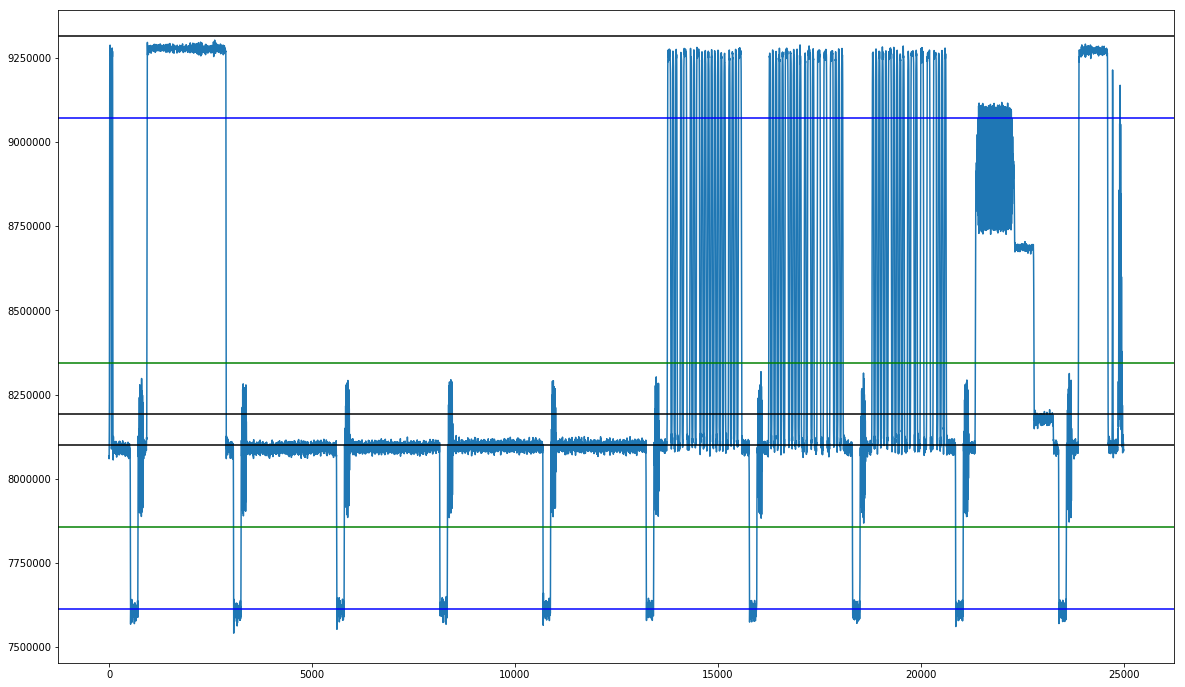

In [38]:
lineplot(tmp['demod'][385000:410000], filterset)
#plt.plot(tmp['demod_05'][1300:4000])
#plt.plot(tmp['demod_burst'][1300:4000] + 7500000)

45.200379329252669

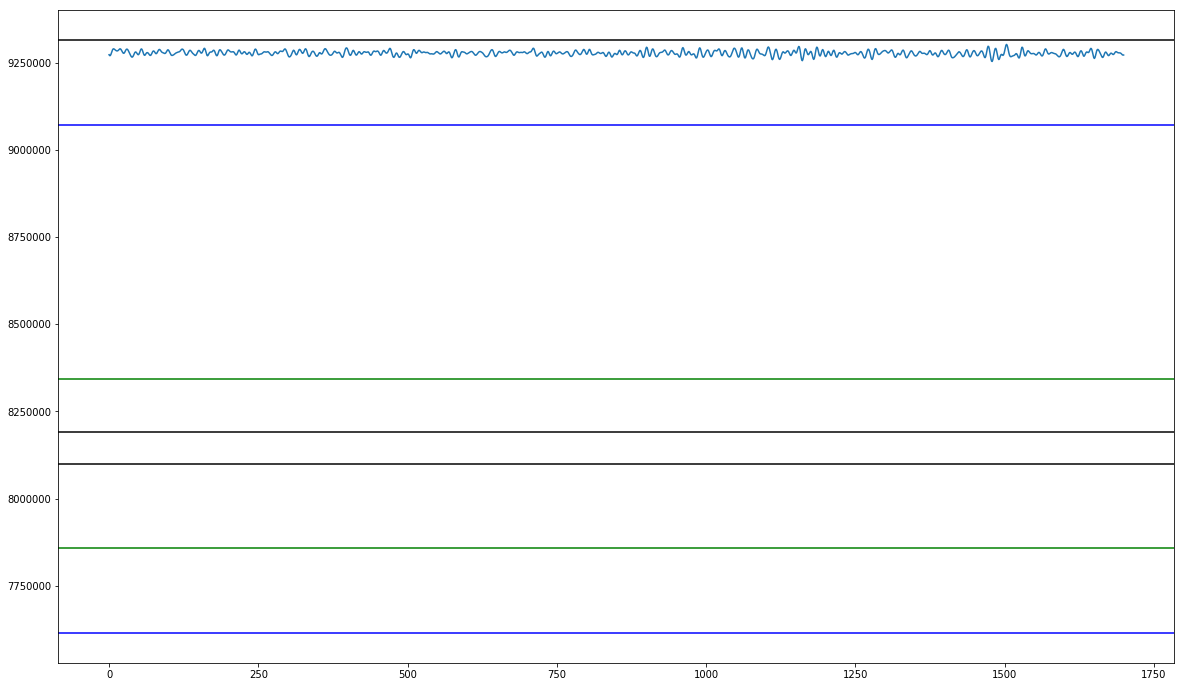

In [41]:
x1 = 386100
x2 = 387800
lineplot(tmp['demod'][x1:x2], filterset)
calcsnr(tmp['demod'][x1:x2])

41.538674613506217

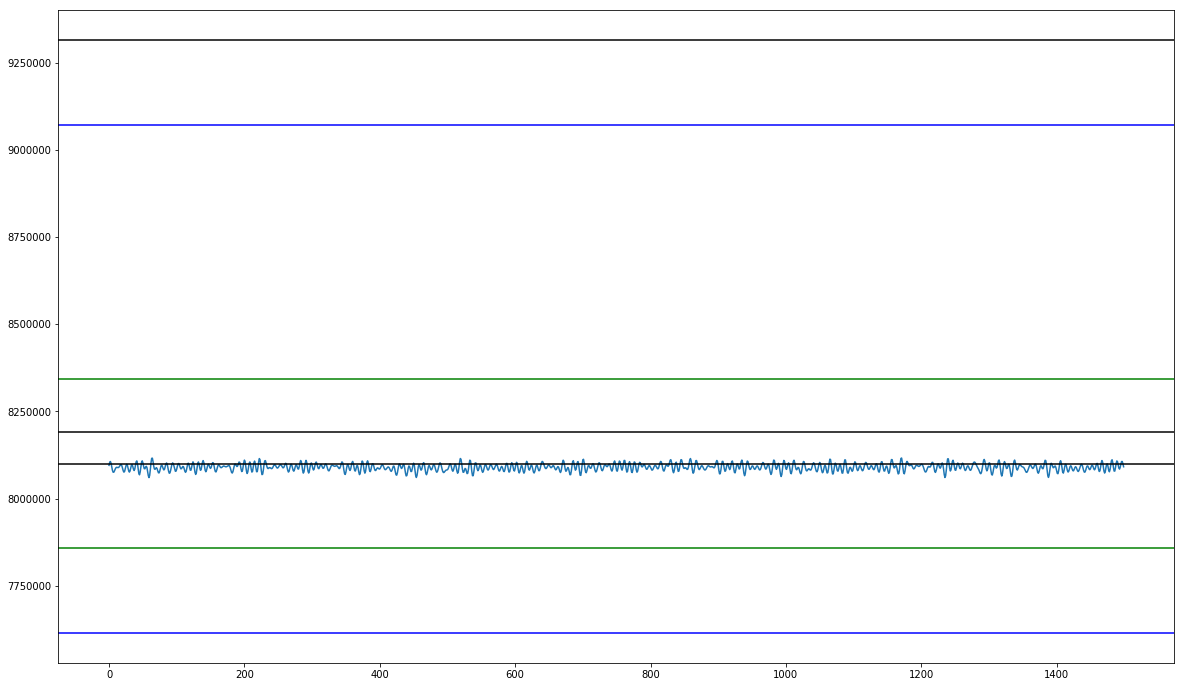

In [42]:
x1 = 388500
x2 = 390000
lineplot(tmp['demod'][x1:x2], filterset)
calcsnr(tmp['demod'][x1:x2])

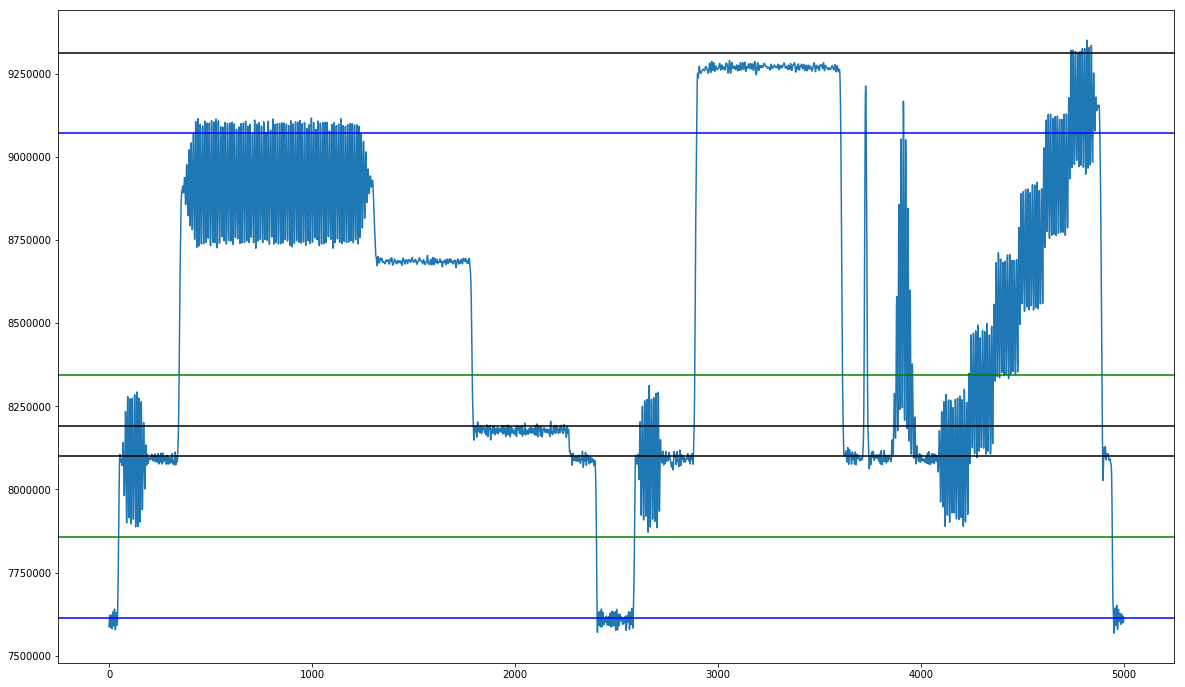

In [44]:
x1 = 406000
x2 = 411000
lineplot(tmp['demod'][x1:x2], filterset)

Below this is the less developed code to deal with NTSC framing and syncs.

A plot of output_syncf here shows a nice pattern overall:

- Vsyncs reach 1.0 (and the mininum in those areas is ~0.23)
- regular hsyncs come in about 0.77 (the glitches are where the LD player "rewinds" for still frames)
- equalization pulses come in about 0.5

In [45]:
output = tmp['demod']
output_sync = tmp['demod_sync']
output_lp = tmp['demod_05']

In [87]:
# state 1: find vsync and first full hsync.  determine which line it is as well...

loc = 0
imglen = (int)((filterset['freq_hz'] / 59.976) * 1.25)

if (loc + imglen) > len(output_sync):
    print("get more data")

# find the next sync point.  should be > .9
syncloc = np.argmax(output_sync[loc:loc+imglen]) + loc

if np.max(output_sync[loc:loc+imglen]) < .9:
    print("oops.  can't find a good sync")

syncloc

372628

In [88]:
def findburstfromsync(syncf, center):
    ilinepx = int(filterset['line_px'])

    if syncf[center] < .2:
        print('invalid location')
    try:
        scanarea = (ilinepx * 6)
        threshold = .15

        startsync = center - scanarea + np.where(syncf[center - scanarea:center] < threshold)[0][-1]
        # note: endsync usually includes the first equalization pulse
        endsync = center + np.where(syncf[center:center + scanarea] < threshold)[0][0]
    except:
        print('oh oh, sync ends not found')

    try:
        lastlinepresync = (startsync - (ilinepx * 4)) + np.where(syncf[startsync - (ilinepx * 4): startsync] > .55)[0][-1]
        # compute equalization length with .08 compensation factor
        presync_eqlen = ((startsync - lastlinepresync) / ilinepx) + .08
    except:
        print("error: couldn't find prev line")
        lastlinepresync = None
        presync_eqlen = None

    try:
        nextline = endsync + np.where(syncf[endsync: endsync + (ilinepx * 4)] > .55)[0][0]
        # the offset is larger here since the first equalization pulse is close enough to the end of vsync
        postsync_eqlen = ((nextline - endsync) / ilinepx) + .56
    except:
        print("error: couldn't find next line")
        nextline = None
        postsync_eqlen = None

    return (lastlinepresync, nextline, presync_eqlen, postsync_eqlen)

prevline, nextline, pregap, postgap = findburstfromsync(output_sync, syncloc)

In [89]:
# state 2: find the (rough) locations of each following line

ilinepx = int(filterset['line_px'])
curloc = nextline

lineinfo = [curloc]
for i in range(0, 253):
    prevloc = curloc
    
    curloc += int(filterset['line_px'] * .9)
    offset = np.argmax(output_sync[curloc:curloc + int(filterset['line_px'] * .2)])
    curloc += offset 
    
    # if the sync detection burst doesn't look good, reuse the last one
    is_validlinegap = inrange((curloc - prevloc), filterset['line_px'] * .997, filterset['line_px'] * 1.003)
    validaftersync = (np.max(output[curloc:curloc + 20]) < 8500000) and (np.min(output[curloc:curloc + 20]) >= 7600000)
    if (i >= 3) and (((output_sync[curloc] < .7) and not is_validlinegap) or not validaftersync):
        print(i, curloc)
        curloc = prevloc + (lineinfo[-1] - lineinfo[-2])
        
#    print(curloc, output[curloc], output[curloc+8])

    lineinfo.append(curloc)


In [92]:
def iretohz(ire):
    return 8100000+(hz_ire_scale*ire)

m20ire = iretohz(-20)

In [93]:
# crude zero-crossing calculator.

def calczc(data, start_offset, target, count=10):
    if data[start_offset] < target:
        locs = np.where(data[start_offset:start_offset+count] >= target)[0]
        offset = 0
    else:
        locs = np.where(data[start_offset:start_offset+count] <= target)[0]
        offset = -1
    
    if len(locs) == 0:
        return None
        
    x = start_offset + locs[0]
    
    a = data[x - 1] - target
    b = data[x] - target
    
    y = -a / (-a + b)

    #print(x, y, locs, data[start_offset:start_offset+locs[0] + 1])

    return x-1+y


In [94]:
lineinfo2 = []

for l in lineinfo:
    zc = calczc(output, l - 5, m20ire, 20)
    
    if zc is None:
        lineinfo2.append(l)
        continue
        
    lineinfo2.append(zc)
    print(l, zc, output[l], output[l + 1], output[l + 2])
    


385710 385711.945402 7726615.92082 7799052.93137 7863519.78778
388253 388254.29904 7790936.07236 7841763.88633 7902746.10782
390794 390795.625164 7752291.35825 7815581.82647 7886632.28192
393336 393337.566957 7756318.21795 7820590.65102 7890100.91726
395878 395879.381814 7769272.95804 7834798.28727 7900803.5026
398420 398421.196264 7778611.70404 7846646.57374 7914684.5988
400962 400963.238482 7765547.81205 7840494.03006 7922286.17584
403504 403504.920462 7782307.98132 7866713.45832 7949672.77005
406045 406046.808167 7749121.72276 7808068.02427 7872326.96313
408587 408588.845109 7747698.44068 7801435.89041 7870733.58836
411129 411130.302891 7746782.53812 7832331.86709 7923678.58375
413671 413672.366689 7787838.41126 7837958.81456 7898067.42611
416212 416213.525991 7735919.8501 7816504.345 7899197.13016
418754 418755.590548 7745360.23125 7816237.66061 7890342.24887
421296 421297.497054 7737224.06154 7817438.53665 7903065.92246
423838 423838.935689 7789389.54473 7864853.14108 7928829.4303

In [95]:
# now to get fine sync!

In [97]:
from scipy import interpolate

# This uses numpy's interpolator, which works well enough
def scale(buf, begin, end, tgtlen):
#        print("scaling ", begin, end, tgtlen)
        ibegin = int(begin)
        iend = int(end)
        linelen = end - begin

        dist = iend - ibegin + 0
        
        sfactor = dist / tgtlen
        
        arr, step = np.linspace(0, dist, num=dist + 1, retstep=True)
        spl = interpolate.splrep(arr, buf[ibegin:ibegin + dist + 1])
        arrout = np.linspace(begin - ibegin, linelen + (begin - ibegin), tgtlen + 1)

        return interpolate.splev(arrout, spl)[:-1]

In [98]:
def downscale(data, lineinfo):
    dsout = np.zeros((len(lineinfo) * ilinepx), dtype=np.double)    

    sfactor = []

    for l in range(0, len(lineinfo) - 1):
        scaled = scale(data, lineinfo[l][0], lineinfo[l][1], 910)
        sfactor.append((lineinfo[l][1] - lineinfo[l][0]) / 910)

        dsout[l * 910:(l + 1)*910] = scaled
        
    return dsout, sfactor

In [99]:
def phasecorrect(sdata, lineinfo, mult = 0.25):
    loutput = []
    errors = []

    #loutput.append(lineinfo[0])
    for l in range(0, len(lineinfo) - 1):
        subset = sdata[l * 910: (l + 1) * 910][5:60]

        if (np.min(subset) < 7600000) or (np.max(subset) > 8500000):
            loutput.append(lineinfo[l])
            errors.append(0)
            continue
        
        peaks = np.where(np.abs(subset - 8100000) > 80000)[0]
        toffset = 0

        for loc in peaks:
            zp = calczc(subset, loc, 8100000)

            if zp is not None:
                offset = (zp - loc - 1)
                toffset += offset
            else:
                offset = 0

    #        print(zp, offset)

        errors.append(toffset)
        #print(l, toffset / len(peaks) * sfactor[l])

        if len(peaks):
            loutput.append(lineinfo[l] - ((toffset * mult) / len(peaks) * sfactor[l]))
        else:
            loutput.append(lineinfo[l])

    loutput.append(lineinfo[-1])
    
    return loutput, errors

In [100]:
def calcerr(subset):
    black = np.mean(subset)
    
    peaks = np.where(np.abs(subset - black) > 100000)[0]
    toffset = 0
    noffsets = 0

    for loc in peaks:
        zp = calczc(subset, loc, black)

        #print(loc, subset[loc], zp)
        
        if zp is not None:
            offset = (zp - loc - 1)
            toffset += offset
            noffsets += 1
        else:
            offset = 0
            
    try:
        return toffset / noffsets
    except:
        return 0


In [101]:
lineinfo_tmp = lineinfo2.copy()
#lineinfo3 = [(lineinfo2[0], lineinfo[1])]
lineinfo3 = [(lineinfo2[0], lineinfo[1])]
badburst = np.zeros_like(lineinfo_tmp)
finalsnr = []

for l in range(1, len(lineinfo2) - 1):
    # hsync check
    scaled = scale(output, lineinfo_tmp[l - 1], lineinfo_tmp[l], 910) 
    subset = scaled[850:910]
    if (np.max(subset) > iretohz(10)) or (np.min(subset) < iretohz(-50)):
        badburst[l] = 1
    
    # color burst check
    #scaled = scale(tmp['demod_burst'] + 8100000, lineinfo_tmp[l], lineinfo_tmp[l + 1], 910) 
    scaled = scale(output, lineinfo_tmp[l], lineinfo_tmp[l + 1], 910) 
    subset = scaled[5:60]
    
    #print(l, np.min(subset), np.max(subset))
    if (np.max(subset) > iretohz(35)) or (np.min(subset) < iretohz(-35)):
        badburst[l] = 1

for l in range(1, len(lineinfo2) - 1):
    for i in range(0, 5):
        # compute 1.2x
        linelen = lineinfo_tmp[l + 1] - lineinfo_tmp[l]
        line12end = lineinfo_tmp[l] + (linelen * 1.2)

        #scaled = scale(tmp['demod_burst'] + 8100000, lineinfo_tmp[l], line12end, 1092) # 1092 is 1.2x 910
        scaled = scale(output, lineinfo_tmp[l], line12end, 1092) # 1092 is 1.2x 910
#        sfactor.append((lineinfo[l + 1] - lineinfo[l]) / 910)

#        lineinfo_tmp[l] -= (offset1 * (linelen / 910) * (.5 / (i + 1)))
        #lineinfo3[l + 1] += (offset1 * (linelen / 910) * .25)
        if not badburst[l]:
            offset1 = calcerr(scaled[5:60])
            lineinfo_tmp[l] += (offset1 * (linelen / 910) * .5)
        else:
            offset1 = None
        if not badburst[l + 1]:
            offset2 = calcerr(scaled[915:970])
            lineinfo_tmp[l + 1] += ((offset2) * (linelen / 910) * .5)
        else:
            offset2 = None

        print(l, i, lineinfo_tmp[l], offset1, offset2, calcsnr((scaled[10:50] + scaled[920:960]) / 2))

            
    lineinfo3.append((lineinfo_tmp[l], lineinfo_tmp[l + 1]))
    linelen = lineinfo3[l][1] - lineinfo3[l][0]
    line12end = lineinfo3[l][0] + (linelen * 1.2)

    scaled = scale(output, lineinfo3[l][0], line12end, 1092) # 1092 is 1.2x 910
    offset1 = calcerr(scaled[0:60])
    offset2 = calcerr(scaled[910:970])
    finalsnr.append(calcsnr((scaled[10:50] + scaled[920:960]) / 2))
    print(l, 'f', offset1, offset2, calcsnr((scaled[10:50] + scaled[920:960]) / 2))
        
#    print(lineinfo_tmp[l + 1], lineinfo3[l][1])
    lineinfo_tmp[l + 1] = lineinfo3[l][1]

finalsnr = []    
    
for i in range(1, len(lineinfo2) - 1):
    if badburst[i] and not (badburst[i - 1] or badburst[i + 1]):
        print(i, lineinfo3[i - 1], lineinfo3[i], lineinfo3[i + 1])
        print((lineinfo3[i - 1][0] + lineinfo3[i + 1][0]) / 2)
        lineinfo3[i] = ((lineinfo3[i - 1][0] + lineinfo3[i + 1][0]) / 2, lineinfo3[i][1])
        lineinfo3[i - 1] = (lineinfo3[i - 1][0], (lineinfo3[i - 1][0] + lineinfo3[i + 1][0]) / 2)

    linelen = lineinfo3[i][1] - lineinfo3[i][0]
    line12end = lineinfo3[i][0] + (linelen * 1.2)
        
    scaled = scale(output, lineinfo3[i][0], line12end, 1092) # 1092 is 1.2x 910
    offset1 = calcerr(scaled[0:60])
    offset2 = calcerr(scaled[910:970])
    finalsnr.append(calcsnr((scaled[10:50] + scaled[920:960]) / 2))
    print(i, 'f', offset1, offset2, calcsnr((scaled[10:50] + scaled[920:960]) / 2))
        
    
lineinfo3.append((lineinfo2[-1], lineinfo2[-1] + linelen))
#lineinfo3.append(lineinfo2[-1])

1 0 385712.294295 0.249762756273 -0.0211510682488 34.1537918452
1 1 385712.454786 0.114908606728 -0.000451743680653 39.1885560341
1 2 385712.515657 0.0435850300597 0.00236547982633 40.8836073751
1 3 385712.536635 0.0150210644621 0.00159382463668 41.0543950396
1 4 385712.543737 0.00508521183253 0.000763743383914 41.0431908979
1 f 0.0293639705987 0.0261059612518 41.032499958
2 0 388254.284163 0.00623317145226 0.24076764867 34.4490080224
2 1 388254.279678 -0.00321175912332 0.10017593309 38.1013920358
2 2 388254.275216 -0.00319441957113 0.0337042243661 39.1821770156
2 3 388254.272773 -0.00174919508542 0.0103922935606 39.3210607338
2 4 388254.27168 -0.000782519418203 0.0031184849761 39.3317018978
2 f 0.0255581056237 0.0223630868677 39.3313625562
3 0 390796.178627 0.00818478969875 0.211647434329 36.2656795251
3 1 390796.17651 -0.00151586372855 0.0804377685093 40.6418574046
3 2 390796.173485 -0.00216642628754 0.0251938174044 41.9354868406
3 3 390796.171728 -0.00125798792473 0.00787766993698 4

23 0 441632.21042 0.00483729437034 0.210072709827 36.0813807486
23 1 441632.206156 -0.00305340736671 0.0829032477346 40.7668579737
23 2 441632.202232 -0.00280909070832 0.0445296372749 42.3989012978
23 3 441632.199593 -0.00188971110186 0.0129688157244 42.695217821
23 4 441632.198337 -0.000899782052226 0.00357859853095 42.6653228274
23 f 0.0246180171033 0.0182362414163 42.6446715172
24 0 444174.105084 0.00896671357544 0.206474238786 35.3940472024
24 1 444174.102685 -0.00171783058336 0.0773416731835 38.3705928009
24 2 444174.0995 -0.00228074929427 0.0247885398805 39.0367027839
24 3 444174.097704 -0.00128599335436 0.00790898510412 39.1153139936
24 4 444174.09688 -0.000589572629085 0.00252064672783 39.1223304614
24 f 0.0169925026391 0.0253548541115 39.1224146867
25 0 446715.953315 0.0154807233216 0.0668597335786 30.5015163565
25 1 446715.959288 0.00427827114459 0.122033808023 31.0548992258
25 2 446715.958074 -0.000869235815346 0.210040601497 32.4483095898
25 3 446715.95178 -0.00450724860211

63 4 543306.481177 -0.00103086892551 0.0042871544819 40.5378630921
63 f 0.0282971322494 0.0557854372486 40.5427124162
64 0 545848.340262 0.0020682180851 0.00902731093152 42.579058469
64 1 545848.340998 0.000527071135884 0.0030100631721 42.5977388521
64 2 545848.341165 0.00012016830042 0.000997392321286 42.6012345163
64 3 545848.341195 2.10687694309e-05 0.00032905404585 42.6020554281
64 4 545848.341196 5.48141492887e-07 0.000108205990294 42.6022878554
64 f 0.0545309525975 0.0253927585145 42.6023608121
65 0 548390.166291 0.00580699679709 0.201353468405 36.0099727174
65 1 548390.163563 -0.00195363950404 0.0753024335292 39.5078281182
65 2 548390.160415 -0.00225355620359 0.020908619707 40.3363476162
65 3 548390.158661 -0.00125645831183 0.00565885189944 40.4270132291
65 4 548390.157853 -0.0005782421238 0.00152126881423 40.4375209071
65 f 0.0251396012647 0.0252590149081 40.4391571498
66 0 550932.004842 0.000223635851341 0.00272459195477 41.9267640506
66 1 550932.004859 1.19645961864e-05 0.000

85 f 0.0334058962153 0.0309946153369 39.1575207693
86 0 601769.610172 0.00613176689968 0.183652196041 35.968265684
86 1 601769.608227 -0.00139312341339 0.0661366651142 38.3516707023
86 2 601769.605701 -0.00180801831551 0.0177011776625 38.7371664345
86 3 601769.604299 -0.0010043547442 0.00473083365668 38.7591489594
86 4 601769.60366 -0.000457094513185 0.00127326951395 38.7575169609
86 f 0.0279735781193 0.0276532284469 38.7562992831
87 0 604311.600294 0.00601459260079 0.117466497357 37.4878433801
87 1 604311.599439 -0.000612459725771 0.0413762020034 38.6010510942
87 2 604311.597929 -0.00108087824994 0.0147429944309 38.7345172584
87 3 604311.597007 -0.000660193517352 0.00526082145451 38.7347709293
87 4 604311.596556 -0.000322992435819 0.00188130595516 38.7277177981
87 f 0.0271168948838 0.0507035983683 38.7241019606
88 0 606853.471767 0.00608068984472 0.23642573582 33.9517030468
88 1 606853.468706 -0.00219187603188 0.0962116499848 37.2955996689
88 2 606853.464858 -0.00275483476826 0.029461

123 4 695826.21227 -0.00185711797866 0.0088379444827 37.9372666168
123 f 0.0273623197404 0.0348774424184 37.9671485611
124 0 698368.480922 0.00952091224137 0.227042943608 35.1576040853
124 1 698368.479002 -0.00137469821707 0.0902836406545 38.943299519
124 2 698368.475725 -0.00234568765387 0.0291231666969 39.984592307
124 3 698368.473739 -0.00142229649734 0.00874842713513 40.1063383287
124 4 698368.472791 -0.000678248078985 0.0026015516146 40.1141811069
124 f 0.0319893146064 0.0115054672588 40.1133281324
125 0 700910.773203 0.00874325499497 0.175997241682 33.265832694
125 1 700910.772221 -0.000703451153757 0.165578721862 35.5772065735
125 2 700910.76702 -0.00372284274036 0.0591230073252 37.6379816311
125 3 700910.763508 -0.00251449543978 0.0178362932629 38.0640738682
125 4 700910.761786 -0.00123247629602 0.00538906523233 38.132529464
125 f 0.0102346187918 0.0289797312009 38.1467326482
126 0 703453.111974 0.00124558809286 0.00589919508324 37.6513879699
126 1 703453.112397 0.0003030316705

145 4 751758.995513 -0.000378597346725 0.00160940636381 41.6814830661
145 f 0.0237074186313 0.00778792273929 41.6748658005
146 0 754301.386996 0.00430521458673 0.206057698462 35.3998626047
146 1 754301.383171 -0.00273830895858 0.0791664988686 38.5540380654
146 2 754301.379527 -0.00260834816069 0.0249990506182 39.2667600994
146 3 754301.377518 -0.00143797241279 0.00792026583696 39.3397257202
146 4 754301.376581 -0.000671025088074 0.00252002611984 39.342795157
146 f 0.00730906912807 0.0342060126145 39.3413389307
147 0 756843.972859 0.0115508609615 0.29763819723 33.039319956
147 1 756843.970439 -0.0017330711901 0.135809393972 38.1712024433
147 2 756843.965845 -0.00328839387594 0.0438253741099 40.7539805119
147 3 756843.962992 -0.0020419632672 0.0129654540692 41.2224330503
147 4 756843.961613 -0.00098772174813 0.0038077392726 41.2890401016
147 f 0.0329559247913 0.0354811690504 41.3010777635
148 0 759386.468763 0.00338572063761 0.044351105605 39.4475172193
148 1 759386.469092 0.000235347807

168 3 810238.067184 -0.00082631219213 0.00374430919005 41.1698628186
168 4 810238.066732 -0.000323244166076 0.000996825544849 41.1632860683
168 f 0.0413444892272 0.0277648574833 41.1606110378
169 0 812780.747908 0.0109412266487 0.156689171349 32.1355391075
169 1 812780.748017 7.828667567e-05 0.210762078859 33.9616218884
169 2 812780.741706 -0.00451799582998 0.0823018331156 36.5119192697
169 3 812780.737228 -0.00320497465797 0.0288122518115 37.1285787943
169 4 812780.734946 -0.00163390129284 0.00994598780674 37.2277183772
169 f 0.02677413685 0.0399420660342 37.2441408711
170 0 815323.40457 0.0109800962968 0.223740824878 34.7092405439
170 1 815323.404368 -0.000144492273502 0.0866003875021 37.6255350678
170 2 815323.401928 -0.00174678559978 0.027413640326 38.299916857
170 3 815323.400248 -0.00120223892534 0.00877746335932 38.3819160103
170 4 815323.399367 -0.00063039412771 0.00279908291829 38.3908913157
170 f 0.0362783704425 0.0385394584951 38.3916857774
171 0 817865.987482 0.000302721645

191 1 868720.98524 0.00177807937019 0.162955878504 36.6773805133
191 2 868720.981905 -0.00238690512037 0.0600848299732 39.2228778264
191 3 868720.978994 -0.00208358242579 0.0209611127092 39.7933806148
191 4 868720.977287 -0.00122159712445 0.00713192369181 39.8890152443
191 f 0.0263078410826 0.0324157415669 39.9063738335
192 0 871263.822179 0.005274572667 0.102795406686 39.8623758314
192 1 871263.822183 2.63912955879e-06 0.0317052894885 41.4051370291
192 2 871263.821321 -0.000617349928143 0.00864835595459 41.6118204171
192 3 871263.820757 -0.000403087073087 0.00232885040917 41.6348092935
192 4 871263.82048 -0.000198476523819 0.000626380954405 41.6382301779
192 f 0.02995307361 0.0191311203533 41.6389624002
193 0 873806.659653 0.00615945969153 0.20446428812 36.1729058782
193 1 873806.656321 -0.0023846625571 0.0784750652116 40.1224874273
193 2 873806.652947 -0.00241516658108 0.0244673338355 41.2389822763
193 3 873806.651155 -0.00128245204213 0.00708178171789 41.3905247894
193 4 873806.6503

229 3 965353.00416 -0.000823147550441 0.00358747216839 43.6537343243
229 4 965353.003673 -0.000348675647911 0.00101953476844 43.6557840633
229 f 0.0320914443143 0.0189162001476 43.6550327485
230 0 967895.975686 0.00385942415396 0.0700738919525 38.9143129497
230 1 967895.975406 -0.000200367399873 0.0218995418562 39.4264188114
230 2 967895.974666 -0.000529257862232 0.00649597075038 39.485021414
230 3 967895.97423 -0.000312471218074 0.00192067997829 39.490652624
230 4 967895.974028 -0.0001439836726 0.000564999656028 39.4911080148
230 f 0.0184922844401 0.0183174324701 39.4911156207
231 0 970438.850001 0.0060484237885 0.198451288257 35.3516245737
231 1 970438.847038 -0.00212061358974 0.0721118787963 38.2109123059
231 2 970438.843907 -0.002240997675 0.0237673182235 38.888038046
231 3 970438.842142 -0.00126311774918 0.00775616744948 39.0013873103
231 4 970438.841314 -0.000592870284354 0.00253298024016 39.0231972991
231 f 0.0179229010219 0.0409169814317 39.0285820574
232 0 972981.743571 -0.000

251 1 1021297.51081 -0.00168796432078 0.0573626331166 39.5471869955
251 2 1021297.50832 -0.00177640529331 0.0189677206607 40.072449801
251 3 1021297.50697 -0.00097241906347 0.00607286423578 40.1510315574
251 4 1021297.50635 -0.000438652862859 0.00191384851883 40.1637073219
251 f 0.00558418603763 0.0273958366873 40.1663239844
252 0 1023840.35049 0.00283671626467 0.0667757273156 36.7780268809
252 1 1023840.35 -0.000347980359872 0.0215349037066 37.0261077666
252 2 1023840.34921 -0.000565084185965 0.00640968317015 37.045436022
252 3 1023840.34875 -0.000333110577593 0.00181430926266 37.0442822481
252 4 1023840.34853 -0.000156183817836 0.000490221972261 37.043213778
252 f 0.0267380971757 0.0146245773256 37.0428261849
1 f 0.0293639705987 0.0261059612518 41.032499958
2 f 0.0255581056237 0.0223630868677 39.3313625562
3 f 0.0211526708281 0.0301261700086 42.1308835449
4 f 0.029061989824 0.0283684765038 41.7640419788
5 f 0.0273441998736 0.0310170015721 43.7769950226
6 f 0.0299959453577 0.028320245

249 f 0.0453565525283 0.027962470433 37.9654848864
250 f 0.0273139947293 0.00604601741004 43.175486518
251 f 0.00558418603763 0.0273958366873 40.1663239844
252 f 0.0267380971757 0.0146245773256 37.0428261849


In [102]:
np.mean(finalsnr), np.min(finalsnr), np.argmin(finalsnr) + 1

(40.617233987443392, 34.766427973881882, 180)

40.6172339874
(230230,)
uint8 (253, 910) (253, 910)


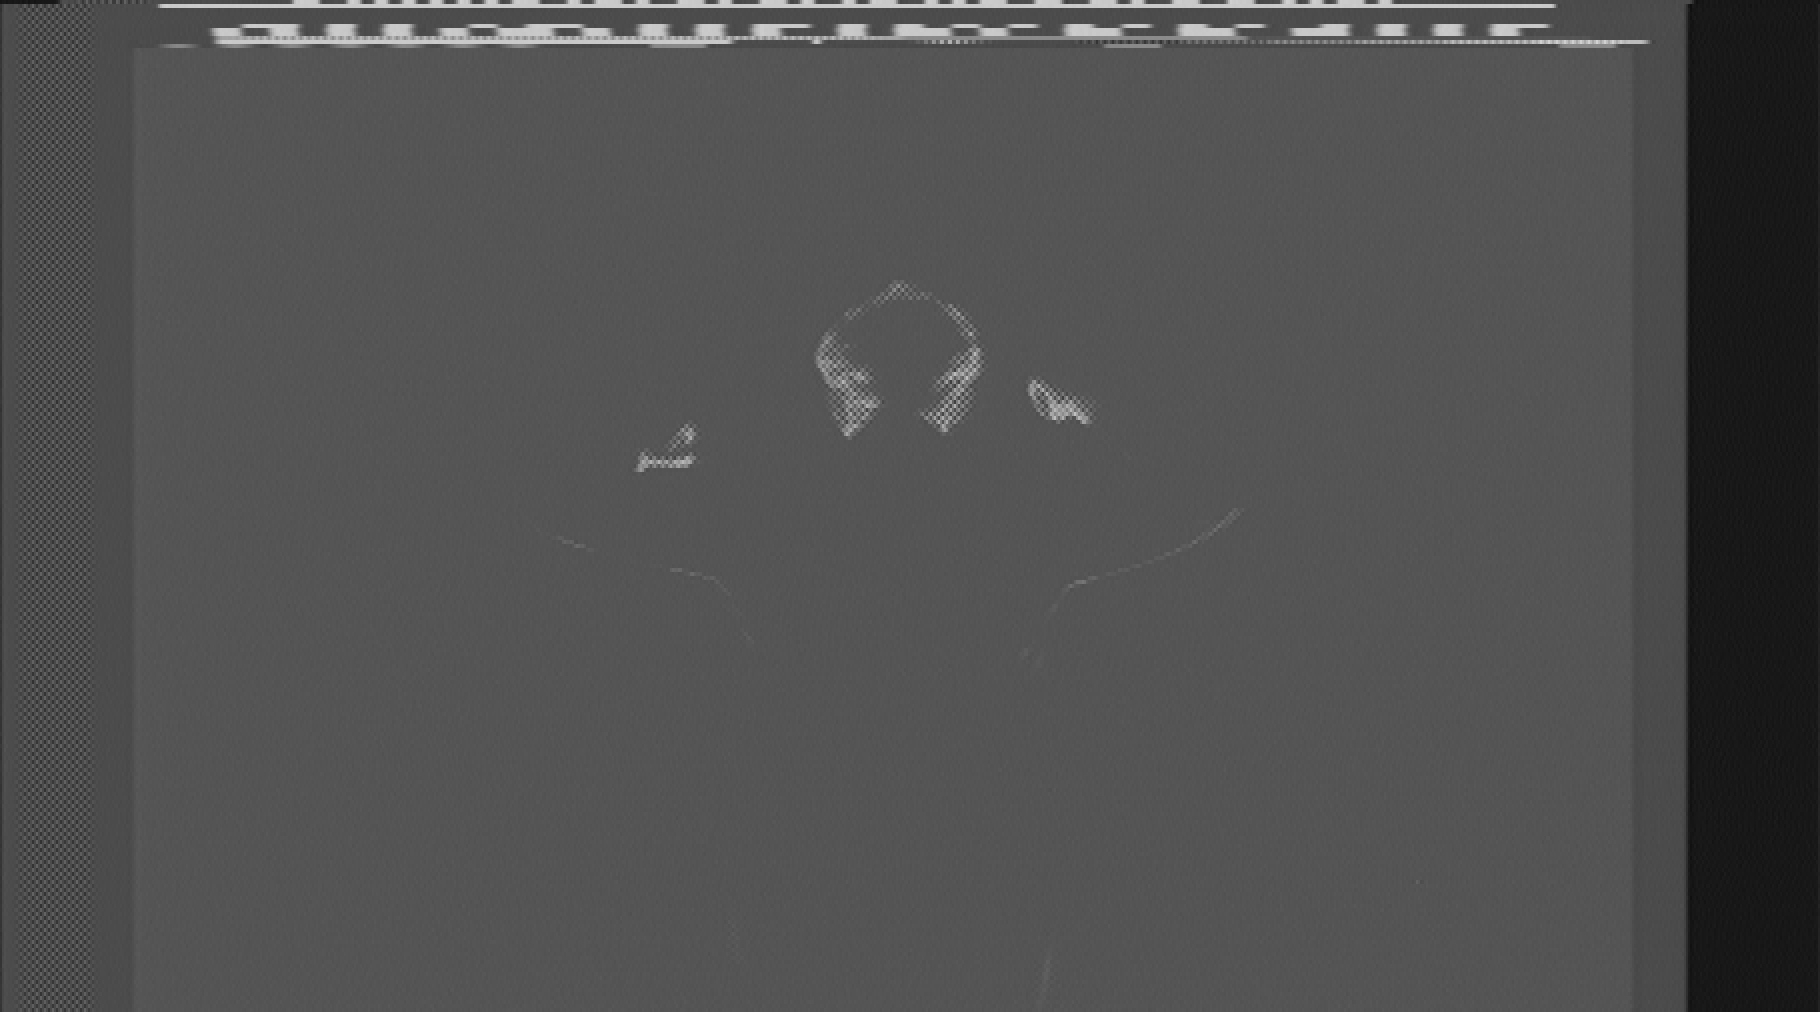

In [104]:
print(np.mean(finalsnr))
lines, sfactor = downscale(output, lineinfo3)

reduced = (lines - minn) / hz_ire_scale
lines16 = np.uint16(np.clip(reduced * out_scale, 0, 65535) + 0.5)

drawdata(lines16, 910, len(lineinfo2)-1, hscale=2, vscale=4)

(44.148546614655615, 38.057093601918204)

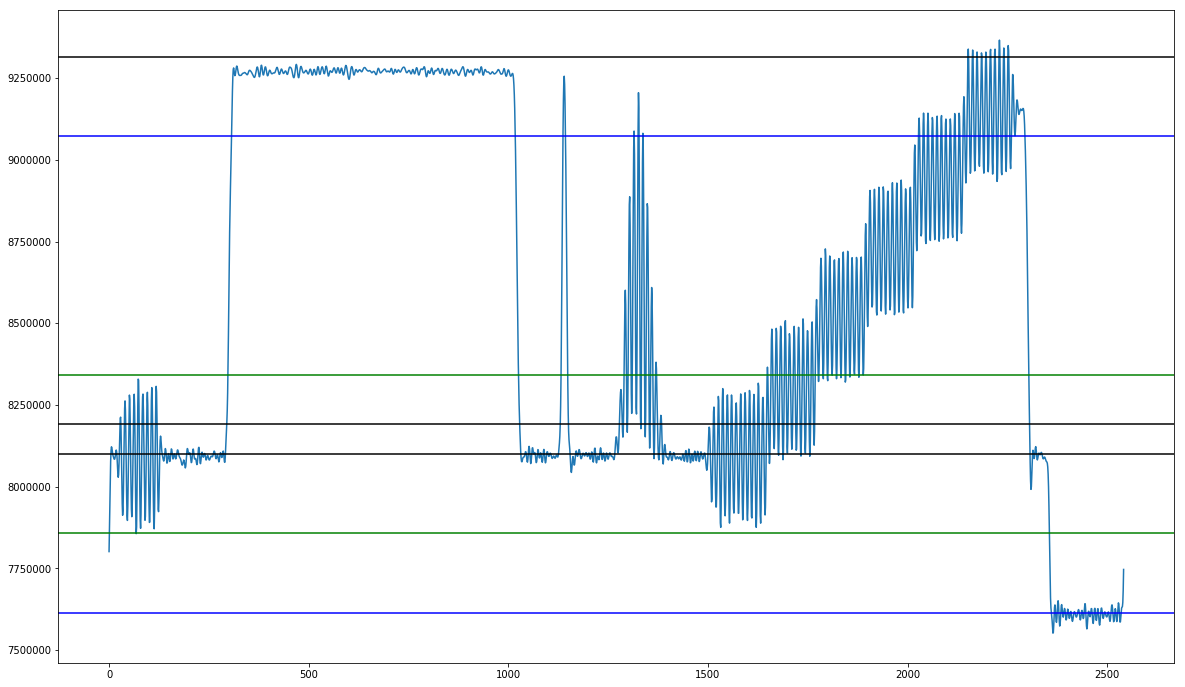

In [105]:
l = 10
x = output[int(lineinfo3[l][0]):int(lineinfo3[l+1][0])]
lineplot(x, filterset)
calcsnr(x[400:900]), calcsnr(x[2400:2530])

(44.552315742672846, 34.6070186239793)

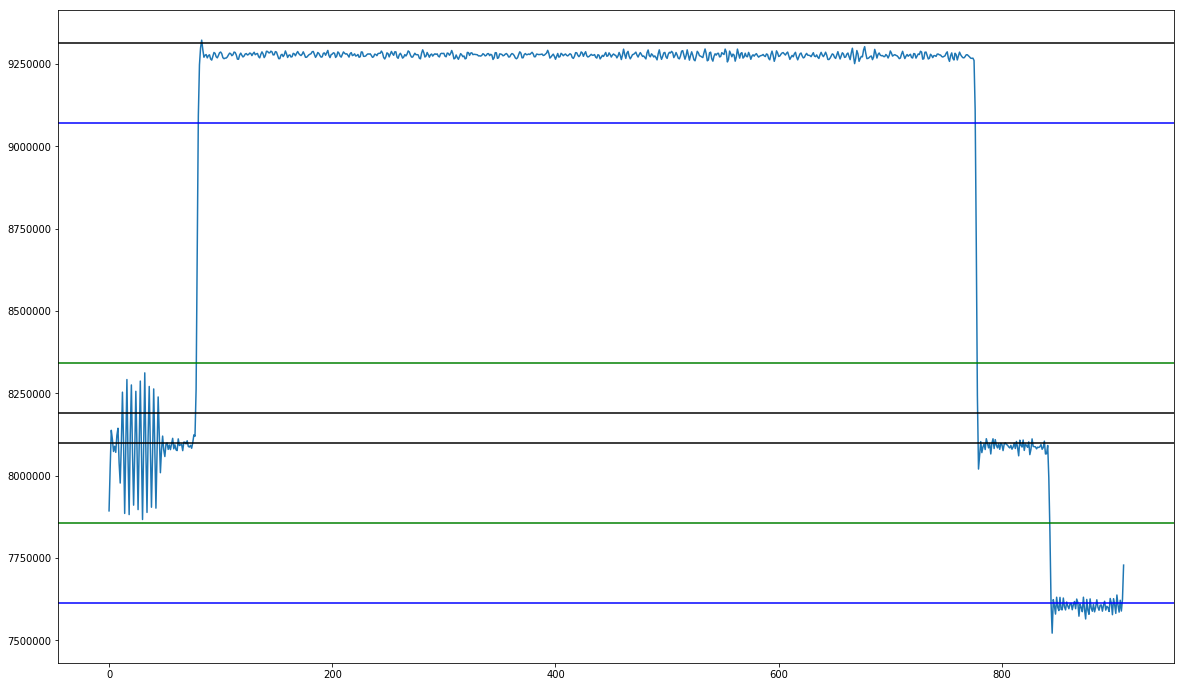

In [108]:
l = 1
x = lines[l * 910:(l + 1) * 910]
lineplot(x, filterset)
calcsnr(x[200:700]), calcsnr(x[850:])

In [109]:
snr = []
zcstart = []
zcend = []
zclen = []
for l in range(2, 250):
    preline = lines[(l * 910) - 20: (l * 910) + 20]
    _line = lines[(l * 910):(l + 2) * 910]
    
    x = lines[(910*l)+0:(910*l)+80]
    y = (x + lines[(910*l)+910:(910*l)+990]) / 2
    #plt.plot(y)

    zcstart.append(calczc(preline, 0, m20ire, 40) - 20)
    zcend.append(calczc(_line, 830, m20ire, 40))
    nextstart = calczc(_line, 900, m20ire, 40)
    zclen.append(nextstart - zcend[-1])
    snr.append(calcsnr(y[15:50]))
    print(l, calczc(preline, 0, m20ire, 40) - 20, calczc(_line, 830, m20ire, 40), calczc(_line, 900, m20ire, 40), calcsnr(y[15:50]))

2 0.0151631468166 842.788099653 909.784091786 39.5527881067
3 -0.2159082138 842.775449311 909.819863919 42.7860444998
4 -0.180136081486 842.701815167 909.816738026 41.423327824
5 -0.183261974218 842.74514033 909.804604906 43.361541802
6 -0.195395093678 842.715676818 909.874343934 41.1862368545
7 -0.125656066265 842.734370737 909.841193021 36.4250390172
8 -0.158806979168 842.842863434 909.851297274 43.2956445368
9 -0.148702725631 842.805637999 909.955539463 37.361353526
10 -0.0444605374509 842.794192504 909.824781243 39.5025531704
11 -0.175218756712 842.690094162 909.931605151 42.2132214558
12 -0.068394848645 842.718859329 909.719118889 41.1753560264
13 -0.280881110782 842.748118951 909.804984402 37.9431640476
14 -0.195015598111 842.792220216 909.821014165 41.2722131436
15 -0.178985834806 842.704231753 909.712751789 39.0875671053
16 -0.287248211196 842.73362096 909.897816535 40.924103391
17 -0.102183464688 842.749238409 909.818404494 37.5809185467
18 -0.18159550563 842.762806147 909.890

In [110]:
np.mean(zclen), np.std(zclen)

(67.113376917523041, 0.082820741956905863)

In [111]:
np.std(zcstart), np.std(zcend), np.mean(snr)

(0.08017659318020183, 0.049347098030023143, 40.564839232126317)

(230230,)
uint8 (253, 910) (253, 910)


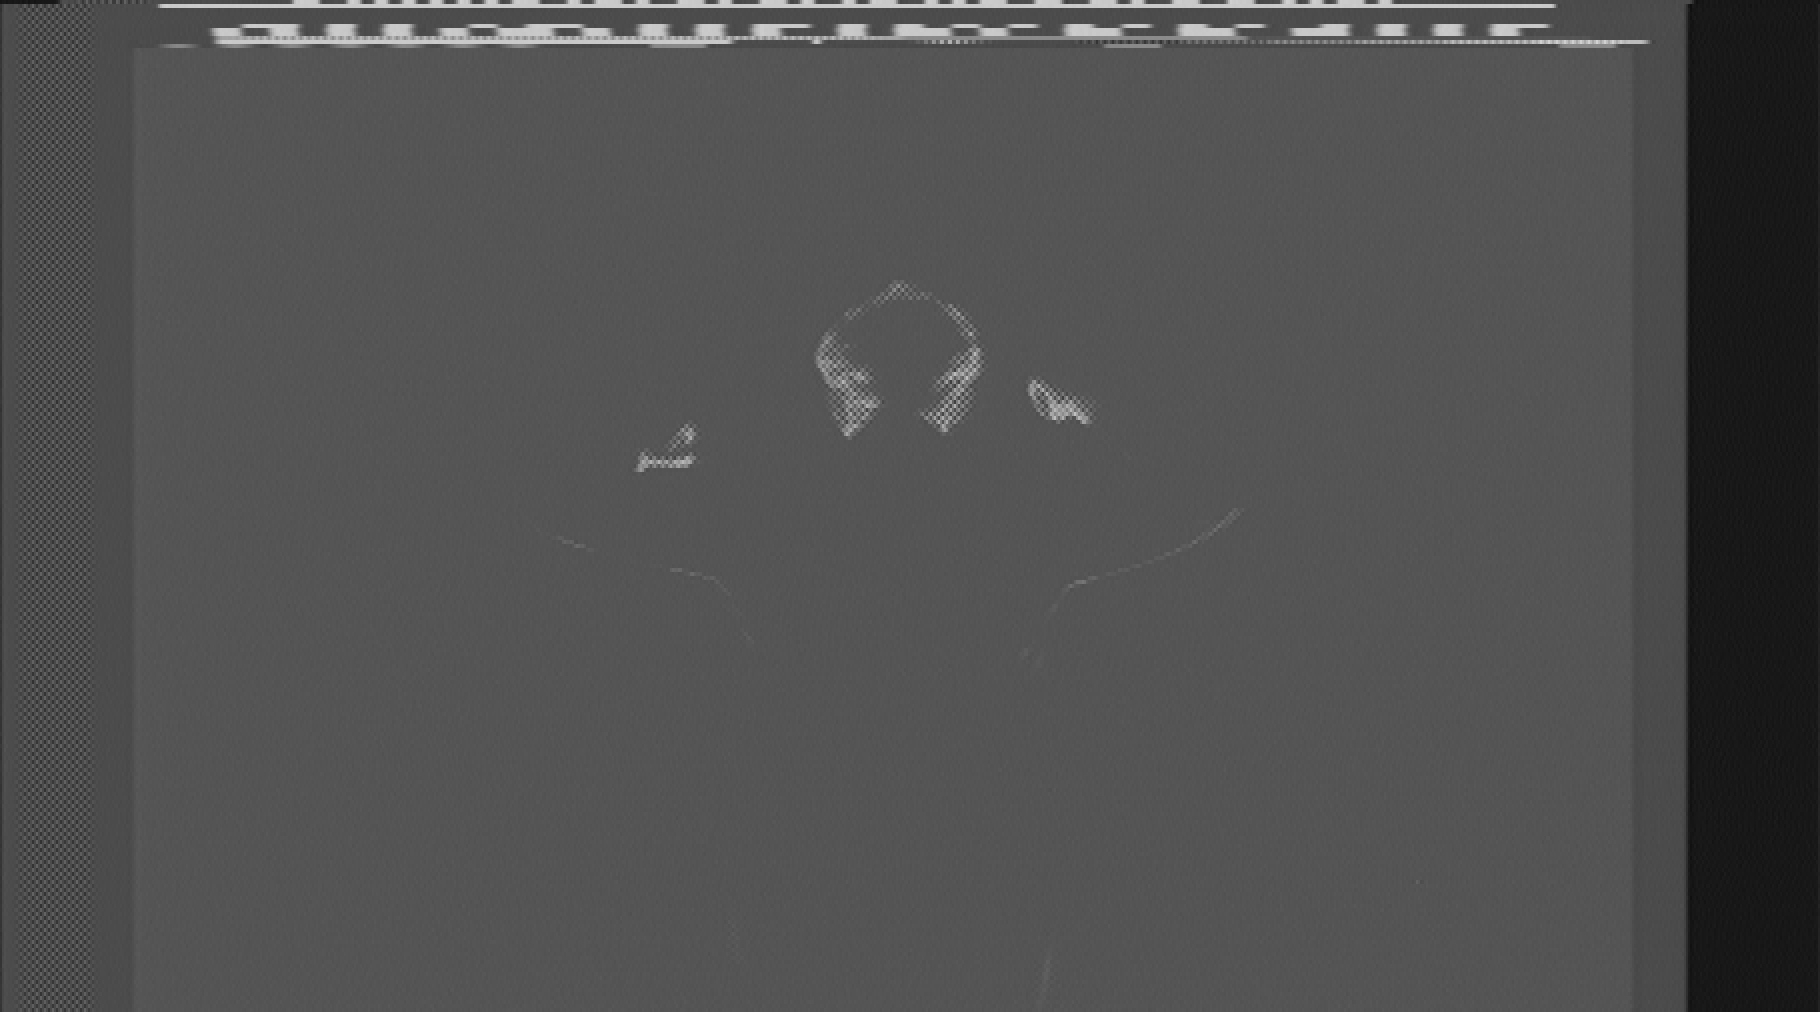

In [114]:
reduced = (lines - minn) / hz_ire_scale
lines16 = np.uint16(np.clip(reduced * out_scale, 0, 65535) + 0.5)

drawdata(lines16, 910, len(lineinfo2)-1, hscale=2, vscale=4)

In [36]:
# figure out where vsync is supposed to begin, assuming line start at ire -20:

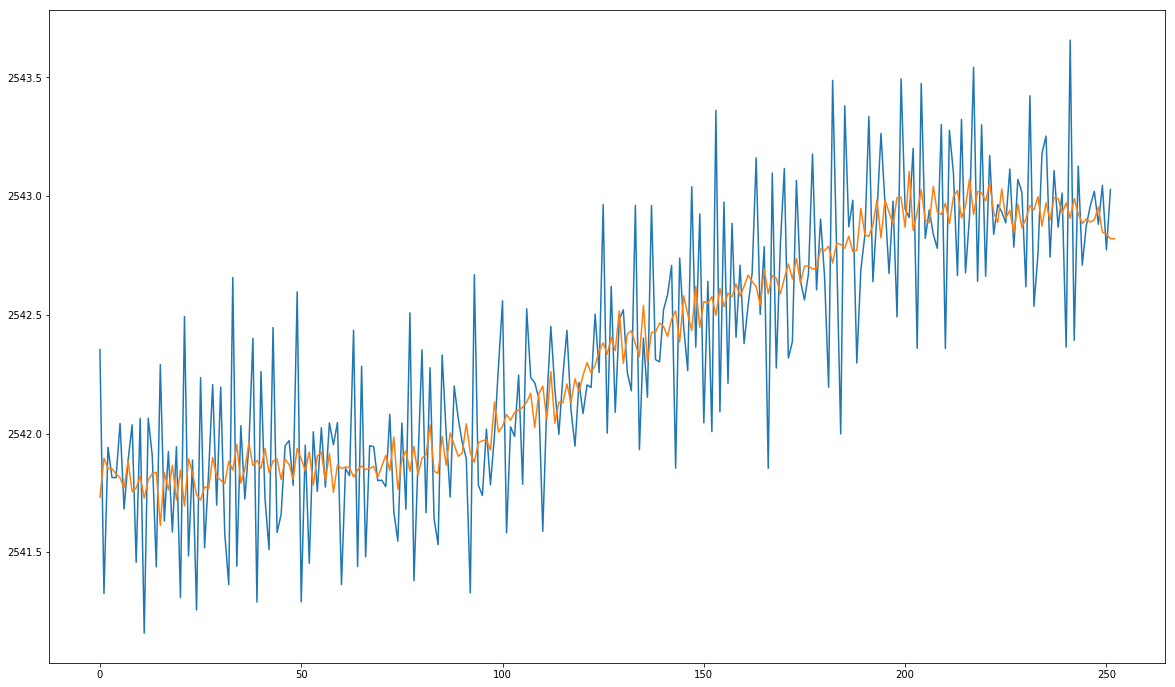

In [117]:
plt.plot(np.diff(lineinfo2[1:]))
plt.plot(np.diff(lineinfo3[1:]))